In [1]:
import pandas as pd

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, WeibullFitter, ExponentialFitter, LogNormalFitter, LogLogisticFitter, WeibullAFTFitter

In [3]:
data = pd.read_csv("telco.csv")

In [4]:
time_column = "tenure"
event_column = "churn"

In [5]:
data[event_column] = data[event_column].map({'Yes': 1, 'No': 0})

In [6]:
kmf = KaplanMeierFitter()

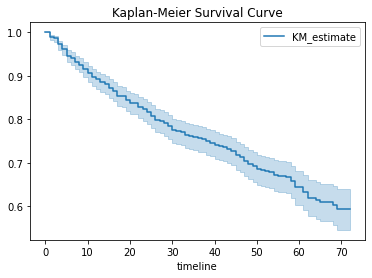

In [7]:
kmf.fit(durations=data[time_column], event_observed=data[event_column])
kmf.plot_survival_function()
plt.title("Kaplan-Meier Survival Curve")
plt.show()

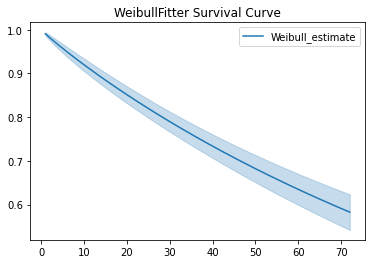

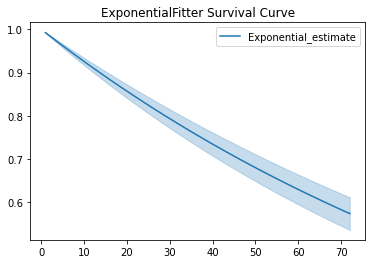

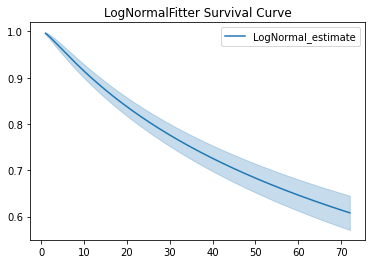

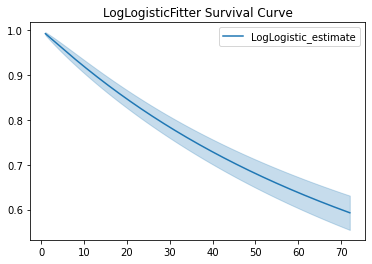

In [8]:
models = [
    WeibullFitter(),
    ExponentialFitter(),
    LogNormalFitter(),
    LogLogisticFitter(),
]

for model in models:
    model.fit(durations=data[time_column], event_observed=data[event_column])
    model.plot_survival_function()
    plt.title(f"{model._class_name} Survival Curve")
    plt.show()

Model Comparison (Lower AIC is better):
WeibullFitter: 3216.8611706815464
ExponentialFitter: 3215.9608134637247
LogNormalFitter: 3209.0351474316735
LogLogisticFitter: 3214.4154757933375

Model Comparison (Lower BIC is better):
WeibullFitter: 3226.676681239511
ExponentialFitter: 3220.868568742707
LogNormalFitter: 3218.850657989638
LogLogisticFitter: 3224.230986351302


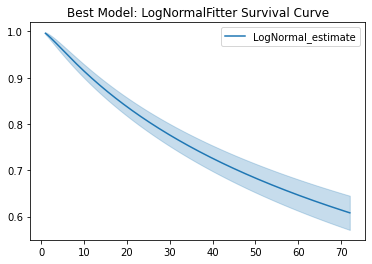

In [9]:
print("Model Comparison (Lower AIC is better):")
for model in models:
    print(f"{model._class_name}: {model.AIC_}")

print("\nModel Comparison (Lower BIC is better):")
for model in models:
    print(f"{model._class_name}: {model.BIC_}")

best_model = min(models, key=lambda model: model.AIC_)
best_model.plot_survival_function()
plt.title(f"Best Model: {best_model._class_name} Survival Curve")
plt.show()

In general, lower values of information criteria such as AIC and BIC indicate a better-fitting model. From the values above, it seems that the LogNormalFitter has the lowest AIC and BIC among the models compared. Therefore, based on the AIC and BIC criteria, the LogNormalFitter appears to be the preferred model among the ones tested.

In [15]:
time_column = "tenure"
event_column = "churn"

selected_features = ['age', 'tenure', 'income', 'marital', 'internet']
data_encode = pd.get_dummies(data, columns=['region', 'ed', 'marital', 'internet', 'custcat', 'retire', 'gender', 'voice', 'forward'], drop_first=True)

aft_model = WeibullAFTFitter()
aft_model.fit(data_encode, duration_col=time_column, event_col=event_column)

coefficients = aft_model.summary
threshold = 0.1
significant_features = coefficients[coefficients['p'] < threshold].index

print(significant_features)

MultiIndex([('lambda_',                              'ID'),
            ('lambda_',                         'address'),
            ('lambda_',                             'age'),
            ('lambda_',               'custcat_E-service'),
            ('lambda_',            'custcat_Plus service'),
            ('lambda_',           'custcat_Total service'),
            ('lambda_', 'ed_Did not complete high school'),
            ('lambda_',           'ed_High school degree'),
            ('lambda_',                 'ed_Some college'),
            ('lambda_',                    'internet_Yes'),
            ('lambda_',               'marital_Unmarried'),
            ('lambda_',                       'voice_Yes'),
            ('lambda_',                       'Intercept'),
            (   'rho_',                       'Intercept')],
           names=['param', 'covariate'])


### CLV

In [21]:
predicted_survival = aft_model.predict_survival_function(data_encode.drop(columns=['churn', 'tenure']))

if isinstance(predicted_survival, pd.DataFrame):
    data_encode['predicted_survival'] = predicted_survival.iloc[:, 0]
else:
    data_encode['predicted_survival'] = predicted_survival

data_encode['expected_lifetime'] = aft_model.predict_expectation(data_encode.drop(columns=['churn', 'tenure']))
data_encode['CLV'] = data_encode['expected_lifetime']

print(data_encode[['ID', 'CLV']])

       ID         CLV
0       1   87.942776
1       2  180.482637
2       3  974.015547
3       4   74.009140
4       5  189.316786
..    ...         ...
995   996   36.874583
996   997   28.140035
997   998  651.329821
998   999  164.350316
999  1000   79.447875

[1000 rows x 2 columns]


In [22]:
data_encode['Age Group'] = pd.cut(data_encode['age'], bins=[18, 30, 40, 50, 60, 100])

segmented_clv = data_encode.groupby('Age Group').agg({
    'ID': 'count',
    'CLV': 'mean'
}).reset_index()

segmented_clv.columns = ['Age Group', 'Customer Count', 'Average CLV']

print(segmented_clv)

   Age Group  Customer Count  Average CLV
0   (18, 30]             208    52.332936
1   (30, 40]             298    95.915313
2   (40, 50]             230   185.546139
3   (50, 60]             178   386.826261
4  (60, 100]              85   730.316113


In [23]:
segmented_clv = data_encode.groupby('ed_High school degree').agg({
    'ID': 'count',
    'CLV': 'mean'
}).reset_index()

segmented_clv.columns = ['Education Level', 'Customer Count', 'Average CLV']

print(segmented_clv)

   Education Level  Customer Count  Average CLV
0                0             713   204.134169
1                1             287   235.421722


### Customer Churn Risk Analysis Report:

In our analysis of customer churn risk, we discovered several noteworthy insights. By interpreting the coefficients from our survival analysis model, we found that factors such as age, education level, and customer category significantly influence churn risk. For instance, customers between 50 to 60 years old exhibit a higher average Customer Lifetime Value (CLV) of $386, indicating a lower churn risk compared to younger age groups. Additionally, customers with a high school degree tend to have a slightly higher CLV, suggesting a slightly increased churn risk compared to those without a high school degree.

The most valuable segments, defined by higher CLV and lower churn risk, include customers aged 50 to 60 and those without a high school degree. This insight is valuable for targeted retention strategies.

To estimate the annual retention budget, we leverage survival probabilities and identify the number of at-risk subscribers within a year. This allows us to allocate resources effectively to retain valuable customers.